### Deriving Greeks from option spreads
Imports data from `adjusted_options` although raw data works fine as well

In [16]:
import datetime
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import multiprocessing
from multiprocessing.pool import Pool
from pathlib import Path

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [17]:
ticker = "CVX"
num_days_year = 253
option_data_path = "data/adjusted_options/"
treasury_yield_path = "data/treasury_yields/"
adj_close_path = "data/adjusted_daily_closing/"
dividend_path = "data/dividends/"
default_save_path = "data/greeks/"

**Load adjusted options data**

In [18]:
try:
    options_df = pd.read_csv(os.path.abspath(os.path.join(option_data_path, (ticker + ".csv"))))
    options_df["date"] = pd.to_datetime(options_df["date"]).dt.date
    options_df["expiration date"] = pd.to_datetime(options_df["expiration date"]).dt.date
except FileNotFoundError:
    raise SystemExit("Option data for " + ticker + " not found in path: " +
                     os.path.abspath(os.path.join(option_data_path, ticker)) + ".csv")

In [19]:
call_options = options_df[options_df["type"] == "call"]
put_options = options_df[options_df["type"] == "put"]

Delta ($\Delta$) at a certain strike price (K) is calculated based off the forward and backward change in strike price. For example, for K=20, the delta at K=19.5 is calculated by taking the slope between K=19 and K=20. Likewise, Delta at K=20.5 is based off ask/bid prices at K=20 and K=21.

Note that the use of midpoint assumes the existence of a monotonic Delta function, which is realistic. For example, the Delta of long calls should decrease from 1 (very ITM) to 0 (very OTM).

Gamma ($\Gamma$) is calculated using the same method, although the monotonic assumption is no longer true.

Because calculated Delta and Gamma values are midpoints between their respective strike prices, the greek values for the original option strikes are **linearly** interpolated.

Since Delta and Gamma are dependent on the price of the underlying, by calculating the amount by which the option is ITM or OTM (dividend adjusted), we create a universal "moneyness" feature.
    - POSITIVE -> ITM
    - NEGATIVE -> OTM

In [20]:
def calc_delta_gamma(input_df, is_call):
    # Calculating Delta
    temp_delta_df = input_df[["strike price", "ask price", "bid price"]].diff()[1:].reset_index(drop=True)
    temp_delta_df.rename(columns={"strike price": "asset change",
                                  "ask price": "ask change",
                                  "bid price": "bid change"},
                         inplace=True)
    # Change in asset price is negative of change in  strike price
    temp_delta_df["asset change"] = -temp_delta_df["asset change"]
    # Strike price for delta to be midpoint between the two options
    temp_delta_df["strike price"] = ((input_df["strike price"][:-1].reset_index(drop=True) +
                                      input_df["strike price"][1:].reset_index(drop=True)) / 2).round(6)
    temp_delta_df["ask"] = temp_delta_df["ask change"] / (temp_delta_df["asset change"])
    temp_delta_df["bid"] = temp_delta_df["bid change"] / (temp_delta_df["asset change"])
    # Add type
    temp_delta_df["type"] = "slope midpoint"

    # Calculating Gamma
    temp_gamma_df = temp_delta_df[["strike price", "ask", "bid"]].diff()[1:].reset_index(
        drop=True)
    temp_gamma_df.rename(columns={"strike price": "asset change",
                                  "ask": "ask change",
                                  "bid": "bid change"},
                         inplace=True)
    temp_gamma_df["asset change"] = -temp_gamma_df["asset change"]
    temp_gamma_df["strike price"] = ((temp_delta_df["strike price"][:-1].reset_index(drop=True) +
                                      temp_delta_df["strike price"][1:].reset_index(drop=True)) / 2).round(6)
    temp_gamma_df["ask"] = temp_gamma_df["ask change"] / temp_gamma_df["asset change"]
    temp_gamma_df["bid"] = temp_gamma_df["bid change"] / temp_gamma_df["asset change"]
    # Add type
    temp_gamma_df["type"] = "slope midpoint"

    # Add on strike prices of actual options
    temp_delta_df = temp_delta_df.merge(input_df[["strike price"]],
                                        how="outer",
                                        on=["strike price"])
    temp_gamma_df = temp_gamma_df.merge(input_df[["strike price"]],
                                        how="outer",
                                        on=["strike price"])

    # Sort order of rows, ignore_index re-indexes for loop below
    temp_delta_df.sort_values(by=["strike price"],
                              inplace=True, ignore_index=True)
    temp_gamma_df.sort_values(by=["strike price"],
                              inplace=True, ignore_index=True)

    for temp_df in [temp_delta_df, temp_gamma_df]:
        # Estimate missing delta/gamma of actual options
        # Special cases
        if np.isnan(temp_df.loc[0, "ask"]):
            # Find FIRST entry available
            temp_df.loc[0, "type"] = "interpolation"
            completed_temp_df = temp_df[-np.isnan(temp_df["ask"])].reset_index(drop=True)
            temp_df.loc[0, ["ask", "bid"]] = completed_temp_df.loc[0, ["ask", "bid"]]
        if np.isnan(temp_df.loc[temp_df.shape[0] - 1, "ask"]):
            # Find LAST entry available
            temp_df.loc[temp_df.shape[0] - 1, "type"] = "interpolation"
            completed_temp_df = temp_df[-np.isnan(temp_df["ask"])].reset_index(drop=True)
            temp_df.loc[temp_df.shape[0] - 1, ["ask", "bid"]] = completed_temp_df.loc[
                completed_temp_df.index[-1], ["ask", "bid"]]
        # Everything in the middle
        for n in range(temp_df.shape[0]):
            if not np.isnan(temp_df.loc[n, "ask"]):
                continue
            else:
                temp_df.loc[n, "type"] = "interpolation"
                # Find the next entry that is not NaN
                forward_shift = 1
                while np.isnan(temp_df.loc[n + forward_shift, "ask"]):
                    forward_shift += 1
                prev_distance = float(temp_df.loc[n, "strike price"] -
                                      temp_df.loc[n - 1, "strike price"])
                next_distance = float(temp_df.loc[n + forward_shift, "strike price"] -
                                      temp_df.loc[n, "strike price"])
                temp_df.loc[n, ["ask", "bid"]] = (((next_distance / (prev_distance + next_distance)) *
                                                   temp_df.loc[n - 1, ["ask", "bid"]]) +
                                                  ((prev_distance / (prev_distance + next_distance)) *
                                                   temp_df.loc[n + forward_shift, ["ask", "bid"]]))
        # Add dates
        temp_df[["date", "expiration date"]] = [np.unique(input_df["date"])[0],
                                                np.unique(input_df["expiration date"])[0]]
        # Amount by which options are ITM or OTM (div adjusted)
        temp_df["moneyness"] = ((np.unique(input_df["closing price"])[0] -
                                 np.unique(input_df["date div"])[0]) -
                                (temp_df["strike price"] -
                                 np.unique(input_df["exp date div"])[0]))
        # for calls, moneyness is (closing - strike); opposite for puts
        if not is_call:
            temp_df["moneyness"] = -temp_df["moneyness"]

        # Drop intermediate columns
        temp_df.drop(columns=["asset change", "ask change", "bid change"], inplace=True)

        # Round ask and bid
        temp_df[["moneyness", "ask", "bid"]] = temp_df[["moneyness", "ask", "bid"]].round(8)

    return [temp_delta_df, temp_gamma_df]

In [21]:
my_pool = Pool(multiprocessing.cpu_count())
is_call = True
call_delta_df = pd.DataFrame()
call_gamma_df = pd.DataFrame()
put_delta_df = pd.DataFrame()
put_gamma_df = pd.DataFrame()

for my_df in [call_options, put_options]:
    delta_df = pd.DataFrame()
    gamma_df = pd.DataFrame()
    input_list = list()
    delta_list = list()
    gamma_list = list()
    if is_call:
        option_type = "call"
    else:
        option_type = "put"

    for my_day in set(my_df["date"]):
        day_df = my_df[my_df["date"] == my_day]
        exp_dates = set(day_df["expiration date"])
        for exp_day in exp_dates:
            input_list.append((day_df[day_df["expiration date"] == exp_day], is_call))
    print(f"done creating {option_type} inputs!")

    pool_results = my_pool.starmap(calc_delta_gamma, input_list)
    print(f"done calculating {option_type} deltas and gammas!")

    # Sort data into lists
    for n in range(len(pool_results)):
        delta_list.append(pool_results[n][0])
        gamma_list.append(pool_results[n][1])

    # Concat each list to a DataFrame
    delta_df = pd.concat(delta_list)
    gamma_df = pd.concat(gamma_list)

    # Rearrange column order
    delta_df = delta_df[["date", "expiration date", "strike price",
                         "moneyness", "ask", "bid", "type"]]
    gamma_df = gamma_df[["date", "expiration date", "strike price",
                         "moneyness", "ask", "bid", "type"]]

    delta_df.sort_values(by=["date", "expiration date"],
                         inplace=True, ignore_index=True)

    gamma_df.sort_values(by=["date", "expiration date"],
                         inplace=True, ignore_index=True)

    if is_call:
        call_delta_df = delta_df
        call_gamma_df = gamma_df
        is_call = False
    else:
        put_delta_df = delta_df
        put_gamma_df = gamma_df

    print(f"finished {option_type} options!")

done creating call inputs!
done calculating call deltas and gammas!
finished call options!
done creating put inputs!
done calculating put deltas and gammas!
finished put options!


In [22]:
print("Delta of Call Options")
print(f"{call_delta_df.iloc[:, :-1].head()} \n")
print("Gamma of Call Options")
print(f"{call_gamma_df.iloc[:, :-1].head()}")

Delta of Call Options
         date expiration date  strike price  moneyness    ask    bid
0  2016-01-04      2016-01-08          45.0  43.920164  0.990  1.010
1  2016-01-04      2016-01-08          47.5  41.420164  0.990  1.010
2  2016-01-04      2016-01-08          50.0  38.920164  0.995  0.995
3  2016-01-04      2016-01-08          52.5  36.420164  1.000  0.980
4  2016-01-04      2016-01-08          55.0  33.920164  1.015  0.985 

Gamma of Call Options
         date expiration date  strike price  moneyness    ask    bid
0  2016-01-04      2016-01-08          45.0  43.920164 -0.002  0.006
1  2016-01-04      2016-01-08          50.0  38.920164 -0.002  0.006
2  2016-01-04      2016-01-08          55.0  33.920164 -0.006 -0.002
3  2016-01-04      2016-01-08          60.0  28.920164 -0.002 -0.006
4  2016-01-04      2016-01-08          65.0  23.920164 -0.034  0.036


Theta ($\Theta$), on the other hand, cannot be derived from a single end-of-day option spread since there has to be the passage of time.

The price of an option (V), is dependent on the price of the underlying (S) and the time to expiry (t). Therefore, by Taylor expansion to its quadratic form, we have:

$dV = \frac{\partial V}{\partial S}dS + \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}dS^2 + \frac{1}{2}\frac{\partial^2 V}{\partial t^2}dt^2 + \frac{\partial^2 V}{\partial S\partial t}dSdt$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`[1]`

If the price of the underlying is **assumed to follow a geometric Brownian motion**, by Ito's lemma, only the $dS^2$ quadratic term can be reduced to a term $\propto dt$.

$dV \approx \frac{\partial V}{\partial S}dS + \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}dS^2$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`[2]`

The Delta-hedge portfolio of $\Pi = V-\frac{\partial V}{\partial S}S$, combined with `[2]` yields:

$d\Pi = \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}dS^2$

If interest rate `r` is compounded continuously, we can solve for the theoretical theta of the option:

$r(V-S\frac{\partial V}{\partial S})dt = \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}dS^2$

$\frac{\partial V}{\partial t} = r(V-S\frac{\partial V}{\partial S}) -
\frac{1}{2}\frac{\partial^2 V}{\partial S^2}\frac{dS^2}{dt}$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`[3]`

Since Theta is a function of Delta, calculated values for listed options are all interpolated.

In [23]:
# Import yields data
one_month = pd.read_csv(os.path.abspath(os.path.join(treasury_yield_path, "1_Month.csv")))
three_month = pd.read_csv(os.path.abspath(os.path.join(treasury_yield_path, "3_Month.csv")))
six_month = pd.read_csv(os.path.abspath(os.path.join(treasury_yield_path, "6_Month.csv")))
one_year = pd.read_csv(os.path.abspath(os.path.join(treasury_yield_path, "1_Year.csv")))
two_year = pd.read_csv(os.path.abspath(os.path.join(treasury_yield_path, "2_Year.csv")))
three_year = pd.read_csv(os.path.abspath(os.path.join(treasury_yield_path, "3_Year.csv")))

one_month["date"] = pd.to_datetime(one_month["date"]).dt.date
three_month["date"] = pd.to_datetime(three_month["date"]).dt.date
six_month["date"] = pd.to_datetime(six_month["date"]).dt.date
one_year["date"] = pd.to_datetime(one_year["date"]).dt.date
two_year["date"] = pd.to_datetime(two_year["date"]).dt.date
three_year["date"] = pd.to_datetime(three_year["date"]).dt.date

# Import closing price and dividends
daily_close = pd.read_csv(os.path.abspath(os.path.join(adj_close_path, f"{ticker}.csv")))
daily_close["date"] = pd.to_datetime(daily_close["date"]).dt.date
dividends_close = pd.read_csv(os.path.abspath(os.path.join(dividend_path, f"{ticker}_ts.csv")))
dividends_close["date"] = pd.to_datetime(dividends_close["date"]).dt.date

min_index = daily_close[daily_close["date"] == np.min(call_options["date"])].index[0]
max_index = daily_close[daily_close["date"] == np.max(call_options["date"])].index[0]
daily_close = daily_close.iloc[min_index:max_index + 2]

daily_close = daily_close.merge(dividends_close, how="left", on="date")

daily_close["adj close"] = (daily_close["close"] - daily_close["amount"]).round(8)
daily_close.drop(columns=["close", "dividend amount", "adjustment factor", "amount"],
                 inplace=True)
daily_close["next day change"] = daily_close["adj close"].diff()[1:].reset_index(drop=True)
daily_close.dropna(axis="rows", inplace=True)

In [24]:
def find_rate(current_date, days_to_exp):
    if days_to_exp >= num_days_year * 2:
        selected_rates = three_year
    elif (days_to_exp >= num_days_year * 1) & (days_to_exp < num_days_year * 2):
        selected_rates = two_year
    elif (days_to_exp >= num_days_year * 1 / 2) & (days_to_exp < num_days_year * 1):
        selected_rates = one_year
    elif (days_to_exp >= num_days_year * 1 / 4) & (days_to_exp < num_days_year * 1 / 2):
        selected_rates = six_month
    elif (days_to_exp >= num_days_year * 1 / 12) & (days_to_exp < num_days_year * 1 / 4):
        selected_rates = three_month
    else:
        selected_rates = one_month

    day_rate = selected_rates[selected_rates["date"] == current_date]["continuous daily rate"]

    while not len(day_rate):
        current_date = (current_date + datetime.timedelta(days=-1))
        day_rate = selected_rates[selected_rates["date"] == current_date]["continuous daily rate"]

    return float(day_rate)


def calc_theta(input_df, delta_df, gamma_df, daily_close_df, my_date):
    # Add treasury yield
    input_df["days to exp"] = np.busday_count(input_df["date"], input_df["expiration date"])
    input_df.sort_values(by=["expiration date", "strike price"],
                         inplace=True, ignore_index=True)
    daily_yield_list = list()
    for exp_day in sorted(list(set(input_df["expiration date"]))):
        temp_df = input_df[input_df["expiration date"] == exp_day]
        days_to_exp = int(np.unique(temp_df["days to exp"]))
        daily_yield_list.extend(np.ones(temp_df.shape[0]) * find_rate(my_date, days_to_exp))

    input_df["treasury yield day"] = daily_yield_list
    input_df.drop(columns=["days to exp"], inplace=True)

    # Add deltas
    temp_theta_df = input_df.merge(delta_df, how="left",
                                   on=["date", "expiration date", "strike price"])
    temp_theta_df.rename(columns={"ask": "delta ask",
                                  "bid": "delta bid",
                                  "type": "delta type"},
                         inplace=True)

    # Add gammas
    temp_theta_df = temp_theta_df.merge(gamma_df, how="left",
                                        on=["date", "expiration date", "strike price"])
    temp_theta_df.rename(columns={"ask": "gamma ask",
                                  "bid": "gamma bid",
                                  "type": "gamma type"},
                         inplace=True)

    # Add closing stock price and next day change
    temp_theta_df = temp_theta_df.merge(daily_close_df, how="left",
                                        on="date")

    # Calculate Thetas
    temp_theta_df["ask"] = (temp_theta_df["treasury yield day"] * (
            temp_theta_df["ask price"] - (temp_theta_df["adj close"] * temp_theta_df["delta ask"])) -
                            (1 / 2) * temp_theta_df["gamma ask"] * (temp_theta_df["next day change"] ** 2)).round(8)

    temp_theta_df["bid"] = (temp_theta_df["treasury yield day"] * (
            temp_theta_df["bid price"] - (temp_theta_df["adj close"] * temp_theta_df["delta bid"])) -
                            (1 / 2) * temp_theta_df["gamma bid"] * (temp_theta_df["next day change"] ** 2)).round(8)

    temp_theta_df = temp_theta_df[["date", "expiration date", "strike price",
                                   "moneyness", "ask", "bid"]]

    temp_theta_df["type"] = "interpolation"

    return temp_theta_df

In [25]:
my_pool = Pool(multiprocessing.cpu_count())
dates = sorted(list(set(call_options["date"])))
call_theta_df = pd.DataFrame()
put_theta_df = pd.DataFrame()

for option_type in ["call", "put"]:
    input_list = list()
    if option_type == "call":
        temp_options_df = call_options
        temp_delta_df = call_delta_df
        temp_gamma_df = call_gamma_df
    elif option_type == "put":
        temp_options_df = put_options
        temp_delta_df = put_delta_df
        temp_gamma_df = put_gamma_df
    else:
        raise Exception("Code coverage purpose, should not reach!")

    for my_date in dates:
        input_list.append((temp_options_df[temp_options_df["date"] == my_date][
                               ["date", "expiration date", "strike price", "ask price", "bid price"]],
                           temp_delta_df[temp_delta_df["date"] == my_date][
                               ["date", "expiration date", "strike price", "moneyness", "ask", "bid"]],
                           temp_gamma_df[temp_gamma_df["date"] == my_date][
                               ["date", "expiration date", "strike price", "ask", "bid"]],
                           daily_close[daily_close["date"] == my_date],
                           my_date))
    print(f"done creating {option_type} inputs!")

    theta_results = my_pool.starmap(calc_theta, input_list)
    print(f"done calculating {option_type} thetas!")

    # Concat into DataFrame
    theta_df = pd.concat(theta_results)

    theta_df.sort_values(by=["date", "expiration date"],
                         inplace=True, ignore_index=True)

    if option_type == "call":
        call_theta_df = theta_df
    elif option_type == "put":
        put_theta_df = theta_df

    print(f"finished {option_type} options!")

done creating call inputs!
done calculating call thetas!
finished call options!
done creating put inputs!
done calculating put thetas!
finished put options!


In [26]:
print("Theta of Call Options")
print(call_theta_df.iloc[:, :-1].head())

Theta of Call Options
         date expiration date  strike price  moneyness       ask       bid
0  2016-01-04      2016-01-08          45.0  43.920164  0.000270 -0.001973
1  2016-01-04      2016-01-08          50.0  38.920164  0.000234 -0.001998
2  2016-01-04      2016-01-08          55.0  33.920164  0.001291  0.000180
3  2016-01-04      2016-01-08          60.0  28.920164  0.000142  0.001237
4  2016-01-04      2016-01-08          65.0  23.920164  0.008873 -0.010329


Visualization of greeks for a specific date and expiration.

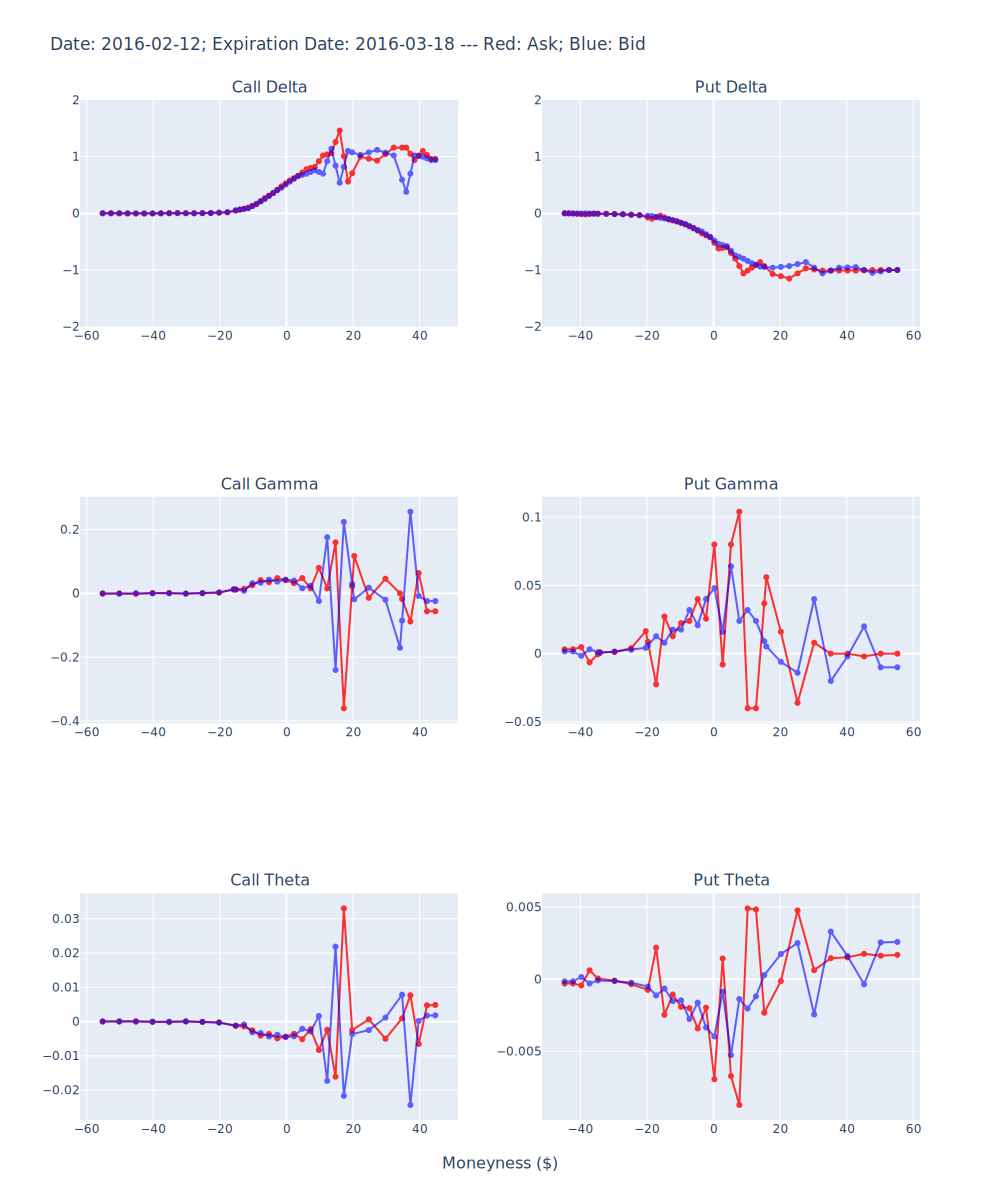

In [42]:
plot_date = datetime.date(2016, 2, 12)
plot_exp_date = datetime.date(2016, 3, 18)

viz_call_delta = call_delta_df[(call_delta_df["date"] == plot_date) &
                               (call_delta_df["expiration date"] == plot_exp_date)]

viz_call_gamma = call_gamma_df[(call_gamma_df["date"] == plot_date) &
                               (call_gamma_df["expiration date"] == plot_exp_date)]

viz_call_theta = call_theta_df[(call_theta_df["date"] == plot_date) &
                               (call_theta_df["expiration date"] == plot_exp_date)]

viz_put_delta = put_delta_df[(put_delta_df["date"] == plot_date) &
                             (put_delta_df["expiration date"] == plot_exp_date)]

viz_put_gamma = put_gamma_df[(call_gamma_df["date"] == plot_date) &
                             (call_gamma_df["expiration date"] == plot_exp_date)]

viz_put_theta = put_theta_df[(put_theta_df["date"] == plot_date) &
                             (put_theta_df["expiration date"] == plot_exp_date)]

if not viz_call_delta.shape[0]:
    raise Exception("Date and/or expiration date combo not valid!")

greek_fig = make_subplots(rows=3, cols=2,
                       x_title="Moneyness ($)",
                       subplot_titles=["Call Delta", "Put Delta",
                                       "Call Gamma", "Put Gamma",
                                       "Call Theta", "Put Theta"])
n_iter = 1
[nrow, ncol] = [1, 1]

for n in [viz_call_delta, viz_put_delta, viz_call_gamma, viz_put_gamma,
          viz_call_theta, viz_put_theta]:
    if n_iter == 2:
        [nrow, ncol] = [1, 2]
    elif n_iter == 3:
        [nrow, ncol] = [2, 1]
    elif n_iter == 4:
        [nrow, ncol] = [2, 2]
    elif n_iter == 5:
        [nrow, ncol] = [3, 1]
    elif n_iter == 6:
        [nrow, ncol] = [3, 2]
    n_iter += 1
    greek_fig.add_trace(go.Scatter(x=n["moneyness"],
                                y=n["ask"],
                                mode='lines+markers',
                                opacity=0.8,
                                marker_color="red",
                                showlegend=False),
                     row=nrow, col=ncol)

    greek_fig.add_trace(go.Scatter(x=n["moneyness"],
                                y=n["bid"],
                                mode='lines+markers',
                                opacity=0.6,
                                marker_color="blue",
                                showlegend=False),
                     row=nrow, col=ncol)

greek_fig.update_layout(title_text=f"Date: {plot_date}; Expiration Date: {plot_exp_date} --- Red: Ask; Blue: Bid")
greek_fig.update_yaxes(row=1, range=[-2, 2])
greek_fig.show("svg", width=1000, height=1200)

**Export data**

In [28]:
Path(default_save_path).mkdir(exist_ok=True)

for option_type in ["calls", "puts"]:
    if option_type == "calls":
        delta_df = call_delta_df
        gamma_df = call_gamma_df
        theta_df = call_theta_df
    else:
        delta_df = put_delta_df
        gamma_df = put_gamma_df
        theta_df = put_theta_df

    delta_df.to_csv(path_or_buf=f"{default_save_path}{ticker}_{option_type}_delta.csv", index=False)
    gamma_df.to_csv(path_or_buf=f"{default_save_path}{ticker}_{option_type}_gamma.csv", index=False)
    theta_df.to_csv(path_or_buf=f"{default_save_path}{ticker}_{option_type}_theta.csv", index=False)
